# Goal

The goal of this notebook is to document how to extract GLMSingle beta values on a specific subject from the bird data setup, do some quality checks etc.
A broad breakdown of these steps are given in the following:

* TBD - when notebook complete

Import libraries and then load up the events data structure to prepare the design matrix for the runs of this subject. Load the CSV file into memory as a pandas `DataFrame` object.

In [4]:
import numpy as np 
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn as nil 
import nilearn.surface as surf
import sklearn
from sklearn.preprocessing import StandardScaler
import glmsingle
from glmsingle.glmsingle import GLM_single

folder = Path('/Users/alxmrphi/Documents/Data/Bird/jamestest/Tc2See_35/study/csv_files')
file = Path('TC2See_35_1_result_store.csv')
path = folder / file

df = pd.read_csv(path, sep='\t')
df.head()

,onset,duration,tr,stimulus,class_id,class_name,image_number,same,response,response_time_ms
0,0.0,10.0,0.00,+,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,5.5,5.00,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,False,NaN,NaN
2,15.5,0.5,7.75,+,NaN,NaN,NaN,NaN,NaN,NaN
3,16.0,5.5,8.00,docs\cropped\182.Yellow_Warbler_2.png,182.0,Yellow_Warbler,2.0,False,NaN,NaN
4,21.5,0.5,10.75,+,NaN,NaN,NaN,NaN,NaN,NaN


We are only interested in the events where an image was presented, so we filter this dataframe by looking for rows that have a string object that ends with `.png`.

In [5]:
events_df = df[df['stimulus'].str.endswith('png')]
events_df.head()

,onset,duration,tr,stimulus,class_id,class_name,image_number,same,response,response_time_ms
1,10.0,5.5,5.0,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,False,NaN,NaN
3,16.0,5.5,8.0,docs\cropped\182.Yellow_Warbler_2.png,182.0,Yellow_Warbler,2.0,False,NaN,NaN
5,22.0,5.5,11.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,True,3.0,3402.803225
7,28.0,5.5,14.0,docs\cropped\172.Nashville_Warbler_1.png,172.0,Nashville_Warbler,1.0,False,NaN,NaN
9,34.0,5.5,17.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,False,NaN,NaN


We now need to replace `stimulus` with its filename (starting after the integer and full stop). Then additionally use the saved mapping between filenames and indices to create another column (called `filename`) with that value.

In [6]:
import pickle 

idx_to_fname = pickle.load(open('idx_to_fname.pkl', 'rb'))
fname_to_idx = pickle.load(open('fname_to_idx.pkl', 'rb'))

In [7]:
def process_stim_column(stimulus):
    assert type(stimulus) == str
    return stimulus.split('.')[1:-1][0]
    
events_df['filename'] = events_df['stimulus'].apply(process_stim_column)
events_df.head()

/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/1836307698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['filename'] = events_df['stimulus'].apply(process_stim_column)


,onset,duration,tr,stimulus,class_id,class_name,image_number,same,response,response_time_ms,filename
1,10.0,5.5,5.0,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,False,NaN,NaN,Palm_Warbler_3
3,16.0,5.5,8.0,docs\cropped\182.Yellow_Warbler_2.png,182.0,Yellow_Warbler,2.0,False,NaN,NaN,Yellow_Warbler_2
5,22.0,5.5,11.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,True,3.0,3402.803225,Yellow_Warbler_4
7,28.0,5.5,14.0,docs\cropped\172.Nashville_Warbler_1.png,172.0,Nashville_Warbler,1.0,False,NaN,NaN,Nashville_Warbler_1
9,34.0,5.5,17.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,False,NaN,NaN,Yellow_Warbler_4


Using the loaded mapping, we now create another column that takes the `filename` and adds a column with the correct filename id.

In [8]:
def stimulus_to_class(stimulus2):
    return fname_to_idx[stimulus2]

events_df['file_id'] = events_df['filename'].apply(stimulus_to_class)
events_df.head()

/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/3489059137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['file_id'] = events_df['filename'].apply(stimulus_to_class)


,onset,duration,tr,stimulus,class_id,class_name,image_number,same,response,response_time_ms,filename,file_id
1,10.0,5.5,5.0,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,False,NaN,NaN,Palm_Warbler_3,203
3,16.0,5.5,8.0,docs\cropped\182.Yellow_Warbler_2.png,182.0,Yellow_Warbler,2.0,False,NaN,NaN,Yellow_Warbler_2,292
5,22.0,5.5,11.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,True,3.0,3402.803225,Yellow_Warbler_4,294
7,28.0,5.5,14.0,docs\cropped\172.Nashville_Warbler_1.png,172.0,Nashville_Warbler,1.0,False,NaN,NaN,Nashville_Warbler_1,171
9,34.0,5.5,17.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,False,NaN,NaN,Yellow_Warbler_4,294


Now we load the corresponding fMRI data (here: surface format) and we can extract the time series and relevant statistics needed to specify the design matrix. 

NB: this is only the left hemisphere. Not sure how you want to do this but I think saving Left vs Right hemisphere separately might be better and then combine them at the downstream stage of ML pipeline. This way it's easier to just load and plot since the fsaverage surfaces are also with split hemispheres.

In [9]:
func_folder = Path('/Users/alxmrphi/Documents/Data/Bird/jamestest/TC2See_35/study/sub-35/sub-35/func')
func_file = Path('sub-35_task-bird_run-1_hemi-L_space-fsaverage_bold.func.gii')

import nilearn as nil 
import nilearn.surface as surf

# load fMRI gii file
func_path = func_folder / func_file
fmri = surf.load_surf_data(func_path)
n_conds = len(fname_to_idx) # number of keys in the mapping dictionary
n_vertices, n_timepoints = fmri.shape

print(f'{n_vertices = }, {n_timepoints = }, {n_conds = }')

n_vertices = 163842, n_timepoints = 236, n_conds = 300


Then you use the same amount of time points as the corresponding processed fMRI data (`n_timepoints`) and create a zeros matrix of shape `(n_timepoints, n_conditions)`. You go through each row and take the corresponding TR value (`tr`) and stimulus ID (`file_id`) and add 1s in the zeros matrix until the design matrix is completed by processing all the rows.

Shapes:

* design = (n_timepoints=236, n_conds=300)
* data = (n_timepoints=236, n_vertices=163842)

In [10]:
design = np.zeros((n_timepoints, n_conds))

for t in range(len(events_df)):
    tr, idx = events_df.iloc[t][['tr', 'file_id']]
    tr = int(tr)
    design[tr, idx] = 1

Now, for every image presentation the TR value found in the same row has been updated to be a `1` in the design matrix. Let's verify this works as expected. We will plot the first two lines of the events dataframe and look at the filename, file_id etc.

In [11]:
events_df.head(2)

,onset,duration,tr,stimulus,class_id,class_name,image_number,same,response,response_time_ms,filename,file_id
1,10.0,5.5,5.0,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,False,NaN,NaN,Palm_Warbler_3,203
3,16.0,5.5,8.0,docs\cropped\182.Yellow_Warbler_2.png,182.0,Yellow_Warbler,2.0,False,NaN,NaN,Yellow_Warbler_2,292


This means we expect that column 203 has a `1` at the 5th `tr` value.

In [12]:
design[5,:].argmax()

np.int64(203)

In [13]:
fname_to_idx['Palm_Warbler_3']

203

The above lines show that column `203` is associated with the file `Palm_Warbler_3` so in the design matrix as expected.

The code below is boilerplate code from the GLMSingle tutorial, can be ignored for now.

In [14]:
opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
print(glmsingle_obj.params)


{'wantlibrary': 1, 'wantglmdenoise': 1, 'wantfracridge': 1, 'wantfileoutputs': [1, 1, 1, 1], 'wantmemoryoutputs': [1, 1, 1, 1], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 50000, 'wanthdf5': 0, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1732619319.067295, 'suppressoutput': 0, 'lambda': 0}


Now let's write a function to load the fMRI data, events file and create the data and design matrices for a specific subject.

In [15]:
def get_data_and_design_matrices(sub_no, run_no):
    """Docstring: TBD """
    func_file = Path(f'sub-{sub_no}_task-bird_run-{run_no}_hemi-L_space-fsaverage_bold.func.gii')
    data = surf.load_surf_data(func_folder / func_file)
    file = Path(f'TC2See_35_{run_no}_result_store.csv')
    path = folder / file
    df = pd.read_csv(path, sep='\t')
    events_df = df[df['stimulus'].str.endswith('png')] 
    events_df['filename'] = events_df['stimulus'].apply(process_stim_column)
    events_df['file_id'] = events_df['filename'].apply(stimulus_to_class)
    design = np.zeros((n_timepoints, n_conds))

    for t in range(len(events_df)):
        tr, idx = events_df.iloc[t][['tr', 'file_id']]
        tr = int(tr)
        design[tr, idx] = 1

    return design, data

Now let's run it on the 6 runs for this subject.

In [16]:
design1, data1 = get_data_and_design_matrices(35, 1)
design2, data2 = get_data_and_design_matrices(35, 2)
design3, data3 = get_data_and_design_matrices(35, 3)
design4, data4 = get_data_and_design_matrices(35, 4)
design5, data5 = get_data_and_design_matrices(35, 5)
design6, data6 = get_data_and_design_matrices(35, 6)

/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/2274337206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['filename'] = events_df['stimulus'].apply(process_stim_column)
/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/2274337206.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['file_id'] = events_df['filename'].apply(stimulus_to_class)
/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/2274337206.py:9: SettingWithCopyWarning: 
A val

Next apply normalisation to the beta values to make them mean-centred and unit standard deviation (for stability and comparability across the fMRI runs). Note that this means you won't need to apply normalisation at a later step in the ML paradigm. I'm not 100% sure if this is required but felt safer to do so. Will check this out later. 99% sure this isn't an issue to apply it at this stage, more of an issue to not apply it and get weird results.

In [17]:
data1_ = StandardScaler().fit_transform(data1)
data2_ = StandardScaler().fit_transform(data2)
data3_ = StandardScaler().fit_transform(data3)
data4_ = StandardScaler().fit_transform(data4)
data5_ = StandardScaler().fit_transform(data5)
data6_ = StandardScaler().fit_transform(data6)

data_list = [data1_, data2_, data3_, data4_, data5_, data6_]
design_list = [design1, design2, design3, design4, design5, design6]

Check shapes

In [18]:
[x.shape for x in data_list]

[(163842, 236),
 (163842, 236),
 (163842, 236),
 (163842, 236),
 (163842, 236),
 (163842, 236)]

In [19]:
[x.shape for x in design_list]

[(236, 300), (236, 300), (236, 300), (236, 300), (236, 300), (236, 300)]

We can combine all the design matrices from each run and plot the overall design matrix for the classes of the images seen.

In [20]:
design_all = np.zeros(design_list[0].shape)
for d in design_list:
    design_all += d

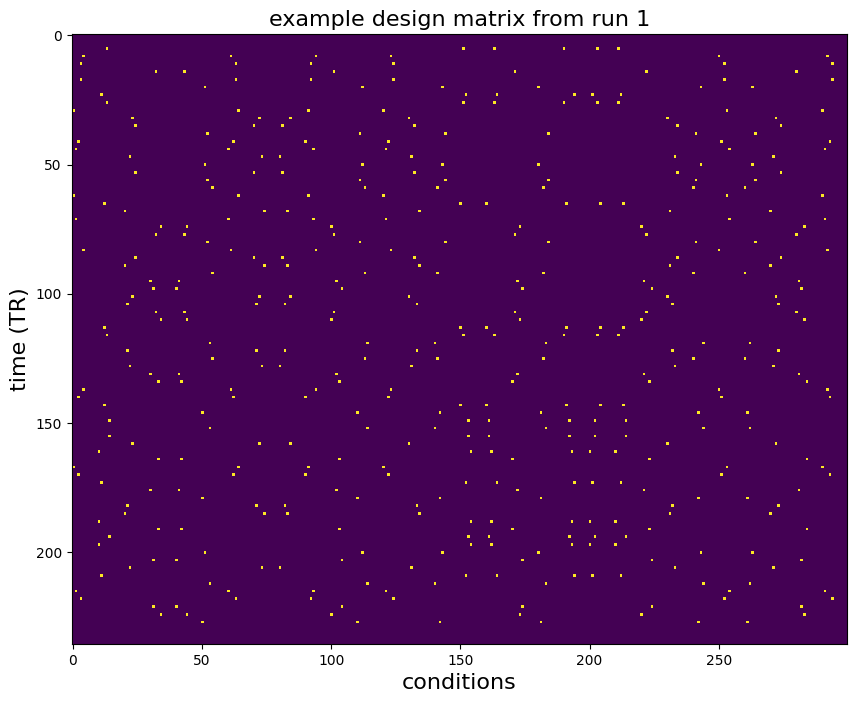

In [21]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10))
plt.imshow(design_all,interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

Okay, so I need to artificially split the runs and have 12 to see what's going on with these repeats. 

In [22]:
print(design_list[0].shape)
print(data_list[0].shape)

(236, 300)
(163842, 236)


One problem with this design is that repeated images are shown in the same run and no image is presented to the subject multiple times across multiple runs. This isn't the format that GLMSingle expects, but authors of the library have said it's okay to split the runs in half and create 12 runs using halves of the original runs and create pseudo-runs where it does look like repeats happen in different runs. This is necessary to get GLMSingle to work. 

In [64]:
split_val = 118

design_list2 = [design_list[0][:split_val,:], design_list[0][split_val:,:], design_list[1][:split_val,:],
                design_list[1][split_val:,:], design_list[2][:split_val,:], design_list[2][split_val:,:],
                design_list[3][:split_val,:], design_list[3][split_val:,:], design_list[4][:split_val,:],
                design_list[4][split_val:,:], design_list[5][:split_val,:], design_list[5][split_val:,:]]

data_list2 = [data_list[0][:,:split_val], data_list[0][:,split_val:], data_list[1][:,:split_val],
                data_list[1][:,split_val:], data_list[2][:,:split_val], data_list[2][:,split_val:],
                data_list[3][:,:split_val], data_list[3][:,split_val:], data_list[4][:,:split_val],
                data_list[4][:,split_val:], data_list[5][:,:split_val], data_list[5][:,split_val:]]

In [65]:
opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
print(glmsingle_obj.params)

tr = 1.97
stimdur = 2.0

results_glmsingle = glmsingle_obj.fit(
    design_list2,
    data_list2,
    stimdur,
    tr,
    outputdir='./output')

{'wantlibrary': 1, 'wantglmdenoise': 1, 'wantfracridge': 1, 'wantfileoutputs': [1, 1, 1, 1], 'wantmemoryoutputs': [1, 1, 1, 1], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 50000, 'wanthdf5': 0, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1732619319.067295, 'suppressoutput': 0, 'lambda': 0}
*** DIAGNOSTICS ***:
There are 12 runs.
The number of conditions in this experiment is 300.
The stimulus duration corresponding to each trial is 2.00 seconds.
The TR (time between successive data points) is 1.97 seconds.
The number of trials in each run is: [38, 37, 38, 37,

/Users/alxmrphi/miniforge3/envs/glmsingle_demo/lib/python3.10/site-packages/glmsingle/glmsingle.py:659: UserWarning: Warning: You have specified trial onsets that occur less than 8 seconds from the end of at least one of the runs. This may cause estimation problems! As a solution, consider simply omitting specification of these ending trials from the original design matrix.
  warnings.warn(msg)


*** Saving FIR results to ./output/RUNWISEFIR.npy. ***

*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to ./output/TYPEA_ONOFF.npy. ***



/Users/alxmrphi/miniforge3/envs/glmsingle_demo/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


*** Setting brain R2 threshold to 0.3795866394939522 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

chunks:  25%|██▌       | 1/4 [00:29<01:28, 29.38s/it]

chunks:  50%|█████     | 2/4 [00:58<00:58, 29.05s/it]

chunks:  75%|███████▌  | 3/4 [01:25<00:28, 28.38s/it]

chunks: 100%|██████████| 4/4 [01:54<00:00, 28.60s/it]



*** Saving results to ./output/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

chunks:  25%|██▌       | 1/4 [00:28<01:26, 28.92s/it]

chunks:  50%|█████     | 2/4 [00:58<00:58, 29.19s/it]

chunks:  75%|███████▌  | 3/4 [01:27<00:29, 29.05s/it]

chunks: 100%|██████████| 4/4 [01:56<00:00, 29.14s/it]



*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 4/4 [00:16<00:00,  4.24s/it]



*** Saving results to ./output/TYPEC_FITHRF_GLMDENOISE.npy. ***

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 4/4 [04:11<00:00, 62.97s/it]



*** Saving results to ./output/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***



*** DIAGNOSTICS ***:
There are 12 runs.
The number of conditions in this experiment is 300.
The stimulus duration corresponding to each trial is 2.00 seconds.
The TR (time between successive data points) is 1.97 seconds.
The number of trials in each run is: [38, 37, 38, 37, 38, 37, 38, 37, 38, 37, 38, 37].
The number of trials for each condition is: [np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(0), np.int64(0), np.int64(0)]


What this is telling me is that condition 5 (from zero-indexing) isn't presented to this subject. But that can't be correct, right? 

In [73]:
idx_to_fname[5]

'Baird_Sparrow_5'

In [71]:
print(sum(design_list2[0][:,5]))
print(sum(design_list2[1][:,5]))
print(sum(design_list2[2][:,5]))
print(sum(design_list2[3][:,5]))
print(sum(design_list2[4][:,5]))
print(sum(design_list2[5][:,5]))

0.0
0.0
0.0
0.0
0.0
0.0


It's true from looking at the .csv files that "Baird_Sparrow_5" is never shown to subject 35.

The returned object contains many useful calculations that could come in handy later, so let's save this object now.

In [148]:
sub_no = 35 
pickle.dump(results_glmsingle, open(f'sub_{sub_no}_glmsingle_results.pkl', 'wb'))

4 levels of results are calculated giving rise to `type[a-d]`, the last of which is the one we want.

In [26]:
results_glmsingle['typed'].keys()

dict_keys(['HRFindex', 'HRFindexrun', 'glmbadness', 'pcvoxels', 'pcnum', 'xvaltrend', 'noisepool', 'pcregressors', 'betasmd', 'R2', 'R2run', 'rrbadness', 'FRACvalue', 'scaleoffset', 'meanvol'])

The results returned from the fitting process for each "type" contain multiple sub-results. The two main ones are R2 (r-squared) and the actual beta values to use. We can use R^2 to verify that the voxels make the most sense (look like they belong to visual cortex). But first, let's see how many images the subject saw by summing up all the values in all of the design matrices.

In [27]:
sum([sum(sum(x)) for x in design_list2])

np.float32(450.0)

450 images were seen. This means we expect per-vertex responses for 450 images. We can access them with this and see the shape here.

In [28]:
results_glmsingle['typed']['betasmd'].shape

(163842, 1, 1, 450)

# TODO 

I have not implemented any code to do the averaging just yet, but you should be able to make it work from this code:

https://htmlpreview.github.io/?https://github.com/kendrickkay/GLMsingle/blob/main/examples/example1.html 

Specifically, go to the section called "Get indices of repeated conditions to use for reliability calculations" and copy the same idea given there. Check with me if any of this is unclear as this needs to be definitely correct, just needs someone to convert that code to our situation and then use that to average the values. 

Beyond that, we can look at the R^2 reliability among muliple image presentations and look to see where the main bulk of activity is coming from.

In [29]:
import nilearn
import nilearn.datasets as datasets
import nilearn.experimental 
from nilearn import datasets
import nilearn.experimental.surface
from nilearn import plotting

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')

In [30]:
results_glmsingle['typed']['R2'].shape

(163842, 1, 1)

In [31]:
r2 = np.squeeze(results_glmsingle['typed']['R2'])
r2 = np.clip(r2, a_min=0, a_max=85)
print(max(r2), min(r2))
r2.shape

67.82618 2.8210113


(163842,)

In [194]:
#view = plotting.view_surf(fsaverage.infl_left, r2, symmetric_cmap=True)
#view

Looking at these values for the left surface, you can see the highest predictive accuracy (r^2) is indeed in the visual cortex and along the early ventral visual pathway.

It doesn't make as much sense to visualise the GLM values averaged together as much as it does to look at r^2 but we can still do it. I did expect the majority of acrtivity to be around the back of the brain (like the r^2) values but it seemed some results are also strong outside the main areas of interest. Note that the authors say this is expected to happen and since we restrict our areas of interest to ones in the Glasser atlas, we won't be looking across the whole brain (but we can do out of curiosity to see if more information might exist). I believe you have implemented a full-brain analysis already.

In [65]:
betasd = np.nanmean(np.squeeze(results_glmsingle['typed']['betasmd']), axis=1)
betasd = np.clip(betasd, a_min=-5, a_max=5)
betasd.shape

(163842,)

In [2]:
#view = plotting.view_surf(fsaverage.infl_left, betasd, symmetric_cmap=True)
#view

## Averaging

Some trials were presented multiple times. We will identify them and average the GLMSingle beta weights together for a strengthened response. 

In [91]:
# consolidate design matrices
designALL = np.concatenate(design_list2,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)
print(corder[:9])

[203 292 294 171 294  51 201 203 290]


This should be that the first three trials of the experiment involved conditions 203, 292 and 294. We can check this.

In [46]:
np.argmax(design_list2[0][5]), np.argmax(design_list2[0][8]), np.argmax(design_list2[0][11])

(np.int64(203), np.int64(292), np.int64(294))

In [50]:
repindices = [] # 2 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    
    # note that for conditions with 3 presentations, we are simply ignoring the third trial
    assert len(temp) <= 3, "More than 3 presentations of a stimulus"
    if len(temp) >= 3:
        repindices.append([temp[0], temp[1], temp[2]])
    elif len(temp) == 2:
        print("Does this occur?")
        repindices.append([temp[0], temp[1]])

repindices = np.vstack(np.array(repindices)).T   

In [55]:
# let's take a look at a few entries
print(repindices[:,:15])

[[233 238 237 227 226 277 231 245 225 273  21  33  14   9  10]
 [244 247 270 229 251 286 281 261 232 275  28  39  41  32  16]
 [279 295 280 296 269 289 293 271 262 288  60  59  67  51  27]]


So the first condition (first bird image in the mapping) is presented at times `233`, `244` and `279`. The 5th condition (a different bird image) was presented at times `226`, `251` and `269`. Let's verify this by looking at the dataframe.

In [93]:
idx_to_fname[233], idx_to_fname[244], idx_to_fname[279]

('Savannah_Sparrow_3', 'Song_Sparrow_4', 'Vesper_Sparrow_9')

In [90]:
betas = np.squeeze(results_glmsingle['typed']['betasmd']).T
print(betas.shape)

trial, n_reps = np.array(repindices).shape
print(f"trial = {trial}, n_reps = {n_reps}")

for i in range(4):
    tmp_reps = repindices[:,i]
    print(f"{tmp_reps = }")
    #print(betas[tmp_reps,:].shape)
    x = designALL[tmp_reps,:]
    print(f"{x.shape = }")
    for j in range(3):
        print(f"{np.argmax(x[j,:]) = }")
    


(450, 163842)
trial = 3, n_reps = 150
tmp_reps = array([233, 244, 279])
x.shape = (3, 300)
np.argmax(x[j,:]) = np.int64(0)
np.argmax(x[j,:]) = np.int64(61)
np.argmax(x[j,:]) = np.int64(0)
tmp_reps = array([238, 247, 295])
x.shape = (3, 300)
np.argmax(x[j,:]) = np.int64(0)
np.argmax(x[j,:]) = np.int64(63)
np.argmax(x[j,:]) = np.int64(113)
tmp_reps = array([237, 270, 280])
x.shape = (3, 300)
np.argmax(x[j,:]) = np.int64(0)
np.argmax(x[j,:]) = np.int64(0)
np.argmax(x[j,:]) = np.int64(60)
tmp_reps = array([227, 229, 296])
x.shape = (3, 300)
np.argmax(x[j,:]) = np.int64(50)
np.argmax(x[j,:]) = np.int64(0)
np.argmax(x[j,:]) = np.int64(0)


In [62]:
fname_to_idx['Palm_Warbler_3']

203

In [63]:
repindices[:,203]

IndexError: index 203 is out of bounds for axis 1 with size 150

In [60]:
run_no = 1
func_file = Path(f'sub-{sub_no}_task-bird_run-{run_no}_hemi-L_space-fsaverage_bold.func.gii')
data = surf.load_surf_data(func_folder / func_file)
file = Path(f'TC2See_35_{run_no}_result_store.csv')
path = folder / file
df = pd.read_csv(path, sep='\t')
events_df = df[df['stimulus'].str.endswith('png')] 
events_df['filename'] = events_df['stimulus'].apply(process_stim_column)
events_df['file_id'] = events_df['filename'].apply(stimulus_to_class)
events_df.head(25)

/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/3280883056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['filename'] = events_df['stimulus'].apply(process_stim_column)
/var/folders/bw/t0cxr5650zs76qhy_qzhs6dm0000gn/T/ipykernel_12847/3280883056.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['file_id'] = events_df['filename'].apply(stimulus_to_class)


,onset,duration,tr,stimulus,class_id,class_name,image_number,same,response,response_time_ms,filename,file_id
1,10.0,5.5,5.0,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,False,NaN,NaN,Palm_Warbler_3,203
3,16.0,5.5,8.0,docs\cropped\182.Yellow_Warbler_2.png,182.0,Yellow_Warbler,2.0,False,NaN,NaN,Yellow_Warbler_2,292
5,22.0,5.5,11.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,True,3.0,3402.803225,Yellow_Warbler_4,294
7,28.0,5.5,14.0,docs\cropped\172.Nashville_Warbler_1.png,172.0,Nashville_Warbler,1.0,False,NaN,NaN,Nashville_Warbler_1,171
9,34.0,5.5,17.0,docs\cropped\182.Yellow_Warbler_4.png,182.0,Yellow_Warbler,4.0,False,NaN,NaN,Yellow_Warbler_4,294
11,40.0,5.5,20.0,docs\cropped\116.Chipping_Sparrow_1.png,116.0,Chipping_Sparrow,1.0,False,NaN,NaN,Chipping_Sparrow_1,51
13,46.0,5.5,23.0,docs\cropped\174.Palm_Warbler_1.png,174.0,Palm_Warbler,1.0,False,NaN,NaN,Palm_Warbler_1,201
15,52.0,5.5,26.0,docs\cropped\174.Palm_Warbler_3.png,174.0,Palm_Warbler,3.0,True,3.0,1476.713773,Palm_Warbler_3,203
17,58.0,5.5,29.0,docs\cropped\182.Yellow_Warbler_0.png,182.0,Yellow_Warbler,0.0,False,NaN,NaN,Yellow_Warbler_0,290
19,64.0,5.5,32.0,docs\cropped\115.Brewer_Sparrow_3.png,115.0,Brewer_Sparrow,3.0,False,NaN,NaN,Brewer_Sparrow_3,23


In [52]:
print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

# now, for each voxel we are going to correlate beta weights describing the
# response to images presented for the first time with beta weights
# describing the response from the repetition of the same image. with 136
# repeated conditions, the correlation for each voxel will reflect the
# relationship between two vectors with 136 beta weights each.

there are 150 repeated conditions in the experiment


In [75]:
results_glmsingle['typed']['betasmd'].shape

(163842, 1, 1, 450)

In [76]:
betas = np.squeeze(results_glmsingle['typed']['betasmd']).T
print(betas.shape)

(450, 163842)


In [113]:
# consolidate design matrices
designALL = np.concatenate(design_list2,axis=0)
n_trs, n_conds = designALL.shape

print(f"{n_trs = }, {n_conds = }")

# construct a vector containing 0-indexed condition numbers in chronological order
cond_order = []
for p in range(n_trs):
    # some TRs are acquired but have no stimulus presentation in them and are all zero, ignore these
    if np.any(designALL[p]):
        tmp = np.argwhere(designALL[p])[0,0]
        #print(tmp)
        cond_order.append(tmp)
        
cond_order = np.array(cond_order)
print(cond_order[:9])

n_trs = 1416, n_conds = 300
[203 292 294 171 294  51 201 203 290]


In [ ]:
len(cond_order), sum(cond_order==4)
# (450, np.int64(3))
# condition '4' was presented three times

(450, np.int64(3))

In [114]:
print(np.argwhere(cond_order==4))
print(np.argwhere(cond_order==4)[:,0])
print(idx_to_fname[4]) 

[[226]
 [251]
 [269]]
[226 251 269]
Baird_Sparrow_4


In [ ]:
des

In [ ]:
repTRs = [] # 2 x images containing stimulus trial indices.
conds_seen = []
cond_trs = []

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for cond in range(n_conds): # loop over every condition
    
    TRs = np.argwhere(cond_order==cond)[:,0] # find TRs where this condition was shown
    
    # note that for conditions with 3 presentations, we are simply ignoring the third trial
    assert len(TRs) == 3, "Investigate potential problem here. Number of presentatinos for this condition != 3"
    if len(TRs) >= 3:
        selected_TRs = [int(TRs[0]), int(TRs[1]), int(TRs[2])]
        repTRs.append(selected_TRs)
        conds_seen.append(cond)
        cond_trs.append((cond, selected_TRs))
        print(f"Condition {cond}. File = {idx_to_fname[cond]}, at TRs {selected_TRs}")

repTRs = np.array(repTRs)
print(f"{repTRs.shape = }")
repTRs = np.vstack(repTRs).T   
print(f"{repTRs.shape = }")
print(len(conds_seen))

Condition 0. File = Baird_Sparrow_0, at TRs [233, 244, 279]
Condition 1. File = Baird_Sparrow_1, at TRs [238, 247, 295]
Condition 2. File = Baird_Sparrow_2, at TRs [237, 270, 280]
Condition 3. File = Baird_Sparrow_3, at TRs [227, 229, 296]
Condition 4. File = Baird_Sparrow_4, at TRs [226, 251, 269]
Condition 10. File = Blue_winged_Warbler_0, at TRs [277, 286, 289]
Condition 11. File = Blue_winged_Warbler_1, at TRs [231, 281, 293]
Condition 12. File = Blue_winged_Warbler_2, at TRs [245, 261, 271]
Condition 13. File = Blue_winged_Warbler_3, at TRs [225, 232, 262]
Condition 14. File = Blue_winged_Warbler_4, at TRs [273, 275, 288]
Condition 20. File = Brewer_Sparrow_0, at TRs [21, 28, 60]
Condition 21. File = Brewer_Sparrow_1, at TRs [33, 39, 59]
Condition 22. File = Brewer_Sparrow_2, at TRs [14, 41, 67]
Condition 23. File = Brewer_Sparrow_3, at TRs [9, 32, 51]
Condition 24. File = Brewer_Sparrow_4, at TRs [10, 16, 27]
Condition 30. File = Canada_Warbler_0, at TRs [105, 117, 132]
Condition

Now with `conds_seen` I can iterate through this list, get the filename, get the TRs, average beta responses and store them somewhere. It will be a NumPy array and it will have a new index over to 150 and inside, it will have the vertex information for that trial as well as what numbered condition (out of the 300 images) it belongs to. Then save this as a NumPy array. Actually maybe separate array for the mapping.

In [ ]:

pickle.dump(cond_trs, open(f'condition_tr_mapping_subject_{sub_no}.pkl', 'wb'))

[(0, [233, 244, 279]),
 (1, [238, 247, 295]),
 (2, [237, 270, 280]),
 (3, [227, 229, 296]),
 (4, [226, 251, 269]),
 (10, [277, 286, 289]),
 (11, [231, 281, 293]),
 (12, [245, 261, 271]),
 (13, [225, 232, 262]),
 (14, [273, 275, 288]),
 (20, [21, 28, 60]),
 (21, [33, 39, 59]),
 (22, [14, 41, 67]),
 (23, [9, 32, 51]),
 (24, [10, 16, 27]),
 (30, [105, 117, 132]),
 (31, [106, 141, 147]),
 (32, [78, 99, 109]),
 (33, [118, 128, 137]),
 (34, [98, 110, 148]),
 (40, [181, 216, 222]),
 (41, [180, 192, 207]),
 (42, [193, 203, 212]),
 (43, [153, 174, 184]),
 (44, [173, 185, 223]),
 (50, [47, 58, 74]),
 (51, [5, 15, 65]),
 (52, [11, 17, 25]),
 (53, [38, 49, 69]),
 (54, [18, 29, 40]),
 (60, [88, 97, 145]),
 (61, [76, 101, 119]),
 (62, [87, 120, 130]),
 (63, [77, 79, 146]),
 (64, [83, 94, 129]),
 (70, [310, 316, 327]),
 (71, [333, 339, 359]),
 (72, [309, 332, 351]),
 (73, [314, 341, 367]),
 (74, [321, 328, 360]),
 (80, [389, 416, 442]),
 (81, [385, 391, 402]),
 (82, [408, 414, 434]),
 (83, [396, 403,

In [145]:
(np.array(conds_seen) == 3)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [151]:
len(repTRs[0])
betas.shape

(450, 163842)

## Indexing Issue

Not all subjects see all conditions, so above if we examine the first ten bird images (conditions) and look at their TRs in the concatenated list, we see:

In [154]:
cond_trs[:10]

[(0, [233, 244, 279]),
 (1, [238, 247, 295]),
 (2, [237, 270, 280]),
 (3, [227, 229, 296]),
 (4, [226, 251, 269]),
 (10, [277, 286, 289]),
 (11, [231, 281, 293]),
 (12, [245, 261, 271]),
 (13, [225, 232, 262]),
 (14, [273, 275, 288])]

Conditions `5-9` were not shown to the subject, so when we do the averaging, which will naturally go from `0-149` then there could be a mismatch. So, we need to store the conditions list so we know what index refers to what. If we loaded the beta values for this subject and we wanted to access the averaged GLMSingle beta response to the image `Blue_winged_Warbler_0` then we first need to get its index value in the whole experiment ... 

In [159]:
fname_to_idx['Blue_winged_Warbler_0']

10

If we look at the `cond_trs` information above, we can see that index 10 occurs at index `5` so we need to always make sure when referencing a specific condition, we look at the index where that is found in the `cond_trs` variable or the `conds_seen` varialbe (which store the same information).

In [161]:
betas[10,:].shape

(163842,)

## Build the Average Version

In [163]:
betas.shape

(450, 163842)

In [164]:
n_repeated_conds = len(repTRs[0])
n_vertices = betas.shape[1]

betas_averaged = np.zeros((n_repeated_conds, n_vertices)) # i.e. (150, 163842) 

for i, (cond, trs) in enumerate(cond_trs):
    betas_averaged[i,:] = np.mean(betas[trs,:], axis=0)
    
pickle.dump(betas_averaged, open(f'betas_averaged_subject_{sub_no}.pkl', 'wb'))

## Saving the Beta Values

We saved all results from fitting the GLMSingle object before, but after averaging across stimulus presentations for the `typed` data, it might be a good idea to save a separate copy for easy access as well, as this is what will go directly into the ML pipeline later.

## Quality Check 

In [168]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

import os 

# output directory for baseline GLM
outputdir_baseline = os.path.join('.','GLMbaseline')

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression


# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed
opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
print(glmbaseline_obj.params)

{'wantlibrary': 0, 'wantglmdenoise': 0, 'wantfracridge': 0, 'wantmemoryoutputs': [1, 1, 0, 0], 'wantfileoutputs': [1, 1, 0, 0], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 50000, 'wanthdf5': 0, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1732619319.067295, 'suppressoutput': 0, 'lambda': 0}


In [177]:
# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.

outputdir_baseline = './baselineGLM'
if not os.path.exists(outputdir_baseline):
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
        design_list2,
        data_list2,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
else:
    
    print(f'loading existing GLMsingle outputs from directory')
    
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(os.path.join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(os.path.join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.

loading existing GLMsingle outputs from directory


In [178]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd']
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

In [179]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them

vox_reliabilities = [] # output variable for reliability values

modelnames = list(models.keys())

# for each beta version...
for m in range(len(modelnames)):
    
    print(f'computing reliability for beta version: {modelnames[m]}')
    
    # get the repeated-condition GLM betas using our repindices variable
    print(models[modelnames[m]].shape)
    tmp = np.squeeze(models[modelnames[m]])
    betas = tmp[:,repTRs] # automatically reshapes to (X x Y x Z x 2 x nConditions)
    x,y,z = betas.shape[:3] 
    
    rels = np.full((x,y,z),np.nan)
    
    # loop through voxels in the 3D volume...
    for xx in range(x):
        for yy in range(y):
            for zz in range(z):
                
                # reliability at a given voxel is pearson correlation between response profiles from first and 
                # second image presentations (dim = 136 conditions)
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]
          
    vox_reliabilities.append(rels)

computing reliability for beta version: assumehrf
(163842, 1, 1, 75)


IndexError: index 233 is out of bounds for axis 1 with size 75

## New way to implement

* Shuffle the conditions so repetitions are out
* Then this should interfere with the ability to get good reps
* Then do the typed for shuffled and unshuffled 
* Then take the subtraction of the R^2 and plot the gain on the hemispheres.

In [180]:
opt = dict()
# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
print(glmsingle_obj.params)

tr = 1.97
stimdur = 2.0

np.random.shuffle(data_list2)

results_glmshuffle = glmsingle_obj.fit(
    design_list2,
    data_list2,
    stimdur,
    tr,
    outputdir='./output')

{'wantlibrary': 1, 'wantglmdenoise': 1, 'wantfracridge': 1, 'wantfileoutputs': [1, 1, 1, 1], 'wantmemoryoutputs': [1, 1, 1, 1], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 50000, 'wanthdf5': 0, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1732619319.067295, 'suppressoutput': 0, 'lambda': 0}
*** DIAGNOSTICS ***:
There are 12 runs.
The number of conditions in this experiment is 300.
The stimulus duration corresponding to each trial is 2.00 seconds.
The TR (time between successive data points) is 1.97 seconds.
The number of trials in each run is: [38, 37, 38, 37,

/Users/alxmrphi/miniforge3/envs/glmsingle_demo/lib/python3.10/site-packages/glmsingle/glmsingle.py:659: UserWarning: Warning: You have specified trial onsets that occur less than 8 seconds from the end of at least one of the runs. This may cause estimation problems! As a solution, consider simply omitting specification of these ending trials from the original design matrix.
  warnings.warn(msg)


*** Saving FIR results to ./output/RUNWISEFIR.npy. ***

*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to ./output/TYPEA_ONOFF.npy. ***



/Users/alxmrphi/miniforge3/envs/glmsingle_demo/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


*** Setting brain R2 threshold to 0.11392115427327491 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

chunks:  25%|██▌       | 1/4 [00:29<01:28, 29.40s/it]

chunks:  50%|█████     | 2/4 [00:58<00:57, 28.96s/it]

chunks:  75%|███████▌  | 3/4 [01:26<00:28, 28.52s/it]

chunks: 100%|██████████| 4/4 [01:56<00:00, 29.03s/it]



*** Saving results to ./output/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

chunks:  25%|██▌       | 1/4 [00:29<01:27, 29.05s/it]

chunks:  50%|█████     | 2/4 [00:57<00:57, 28.88s/it]

chunks:  75%|███████▌  | 3/4 [01:26<00:28, 28.87s/it]

chunks: 100%|██████████| 4/4 [01:54<00:00, 28.73s/it]



*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]



*** Saving results to ./output/TYPEC_FITHRF_GLMDENOISE.npy. ***

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 4/4 [04:13<00:00, 63.30s/it]



*** Saving results to ./output/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***



In [191]:
r2_real = results_glmsingle['typed']['R2']
r2_shuffle = results_glmshuffle['typed']['R2']

gain = r2_real - r2_shuffle

In [192]:
gain.shape

(163842, 1, 1)

Plot the difference.

In [195]:
#view = plotting.view_surf(fsaverage.infl_left, gain, symmetric_cmap=True)
#view

Here we see that when we shuffled `data_list2` such that the condition and temporal order was not in the correct order, there is a drop in the `R2` value, particularly in visual cortex in the occipital lobe. This tells us that when we used the original ordering, there is a gain in `R2`. This result confirms that the signal is likely correct in the setup derived to get these beta values in our experimental setup. 